# **Lab 5a: Land Cover Classification Using Machine Learning: An Introductory Guide with Scikit-Learn**

## Introduction
This lab introduces participants to the application of machine learning algorithms for land cover classification using satellite imagery. Land cover classification is a fundamental task in remote sensing, supporting a wide range of applications including environmental monitoring, urban planning, agriculture, and natural resource management.

In this lab, we explore and compare the performance of four commonly used machine learning classifiers k-nearest neighbor (KNN), support vector machines, decision trees, and random forest classifiers. These classifiers are implemented using the Scikit-Learn library in a Google Colab environment, making the lab accessible and easy to follow without requiring local software installations. Participants will learn how to load training and testing data, preprocess features, train different models, assess their performance using accuracy metrics, and visualize classification results.

### Why use Scikit-Learn and Google Colab?
- Scikit-Learn provides a user-friendly API for a variety of machine learning algorithms (e.g., Decision Trees, Random Forests, SVM, KNN, etc.).
- Google Colab gives you free access to a remote environment with preinstalled libraries, GPU/TPU access, and easy integration with Google Drive.

### Goal
By the end of this lab, participants will have a foundational understanding of how to apply and evaluate basic machine learning algorithms for classifying land cover types from Earth observation data.


## Imports and Setup
### Install libraries
First, install any additional libraries that are not installed by default (e.g., rasterio, earthpy)..

In [ ]:
# Install some packages
!pip install rasterio
!pip install earthpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.0 MB/s eta 0:00:00


### Import libraries
Import the necessary libraries (pandas, numpy, scikit-learn, rasterio, etc.).

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import rasterio
import earthpy.plot as ep
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

### Mount Google Drive
Next, mount your Google Drive. You will be prompted to authorize access to your Google Drive. Once mounted, you can read/write files in /content/drive/MyDrive.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define paths and variables
Define the the paths to access your own directory structure in Google Drive. In this tutorial, we use:
-A CSV training dataset (Bul_TrainingData_2024.csv) containing pixel values and their corresponding classes.
- A multiband Sentinel-2 image (Bul_S2_2024.tif).

In [ ]:
# Define path that contains the datasets
Sample_Path = '/content/drive/MyDrive/Bulawayo_Dataset_2024/Bul_TrainingData_2024.csv'
Image_Path = '/content/drive/MyDrive/Bulawayo_Dataset_2024/Bul_S2_2024.tif'

### Define target and predictor variables
Next, define and specify the overall structure of the land cover classification task. Bands lists the Sentinel-2 spectral bands (e.g., B2, B3, B4) used as input features (predictors) for the model, while LC indicates the target column named “class.” Classes is a list of integer codes that the model will learn to predict, and N_Classes denotes the total number of these categories. The Names list provides descriptive labels (e.g., “Bare area,” “Built-up”) that match each code, making it easier to interpret results. Finally, Palette is a set of hex color codes for visualizing each class in plots or exported maps.

In [ ]:
# Define target and predictor variables
Bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B11', 'B12']  # Feature columns
LC = ['class']

Classes = [0, 1, 2, 3, 4, 5]
N_Classes = 6
Names   = ["Bare area", "Built-up", "Cropland", "Grassland", "Woodland", "Water"]
Palette = [
    '#D3D3D3',  # grey for class 0 (Bare area)
    '#FF0000',  # red for class 1 (Built-up)
    '#FFD700',  # gold for class 2 (Cropland)
    '#ADFF2F',  # greenyellow for class 3 (Grassland)
    '#006400',  # darkgreen for class 4 (Woodland)
    '#0000FF'   # blue for class 5 (Water)
]

## Load the Sentinel-2 Imagery
We will use rasterio to open the .tif file. Sentinel-2 imagery often has multiple bands (e.g., 13 bands). In this guide, we will specifically use the bands listed in our Bands variable (B2, B3, B4, etc.).

Image has 9 bands.
Image dimensions: 4469 rows x 5317 columns
Coordinate Reference System (CRS): EPSG:4326


/usr/local/lib/python3.11/dist-packages/earthpy/spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


<Figure size 800x800 with 0 Axes>

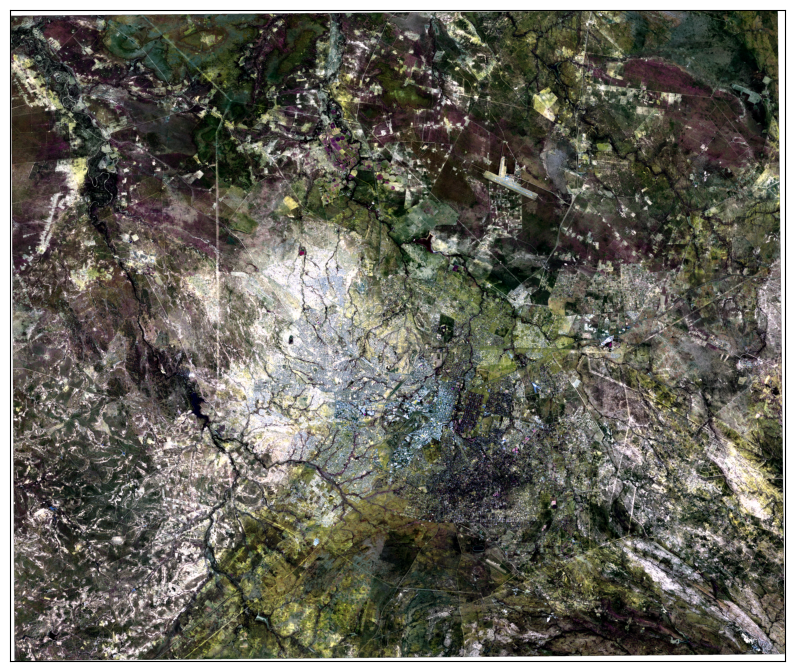

In [ ]:
# Open the multiband Sentinel-2 image
image = rasterio.open(Image_Path)

band_count = image.count
height = image.height
width = image.width
crs = image.crs
transform = image.transform

print(f"Image has {band_count} bands.")
print(f"Image dimensions: {height} rows x {width} columns")
print(f"Coordinate Reference System (CRS): {crs}")

# For quick visualization (RGB = bands 4, 3, 2 if the image bands are in order)
# If your image bands are in the order B2=1, B3=2, B4=3, ... B12=9,
# then B4 is band index 3 in a 1-based system, so read(3):
# Adjust these indices if necessary
image_vis = []
for b in [4, 3, 2]:  # Using B4, B3, B2 for a true color composite
    image_vis.append(image.read(b))
image_vis = np.stack(image_vis)

plt.figure(figsize=(8,8))
ep.plot_rgb(
    image_vis,
    stretch=True
)
plt.show()

##  Load and Prepare Training Data
Next, load and prepare the training data. The training data is in a CSV format with columns for each band (B2, B3, etc.) and a class column (land cover type).

In [ ]:
# Load training data as a DataFrame
df = pd.read_csv(Sample_Path)

# Inspect first few rows
print(df.head())

# Separate features (X) and label (y)
X = df[Bands]
y = df['class']

# Ensure no missing values
print(f"Missing values in features: {X.isnull().sum().sum()}")
print(f"Missing values in label: {y.isnull().sum()}")

# Split into training and testing subsets
# (you can also do cross-validation if you prefer)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

   system:index      B11      B12      B2       B3       B4      B5      B6  \
0             0  0.18410  0.13230  0.0379  0.04790  0.05980  0.0883  0.1197   
1             1  0.26330  0.19170  0.0490  0.06770  0.08980  0.1253  0.1636   
2             2  0.15300  0.10990  0.0322  0.04770  0.04680  0.0795  0.1322   
3             3  0.43365  0.38825  0.1145  0.16795  0.22625  0.2572  0.2794   
4             4  0.38520  0.33210  0.0947  0.12220  0.16200  0.1874  0.1994   

       B7      B8  class                                    .geo  
0  0.1346  0.1416      0  {"type":"MultiPoint","coordinates":[]}  
1  0.1854  0.1985      0  {"type":"MultiPoint","coordinates":[]}  
2  0.1466  0.1577      0  {"type":"MultiPoint","coordinates":[]}  
3  0.2934  0.2926      0  {"type":"MultiPoint","coordinates":[]}  
4  0.2170  0.2266      0  {"type":"MultiPoint","coordinates":[]}  
Missing values in features: 0
Missing values in label: 0
Training samples: 17992
Testing samples: 7711


## Exploratory Data Analysis (EDA)
Exploratory data analysis (EDA) is a critical initial step in the geospatial machine learning workflow. It involves the use of statistical summaries, visualizations, and spatial analysis techniques to gain insights into the structure, quality, and patterns present in the dataset before applying any classification algorithm.

### Class distribution
First, create a count plot of 'class' to show the distribution of training samples for each land cover class. EDA helps assess the balance of land cover classes (e.g., forest, water, urban, agriculture) within the dataset. Imbalanced class distributions can negatively affect model performance, especially in classification tasks.

<ipython-input-8-a79b57ed7388>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


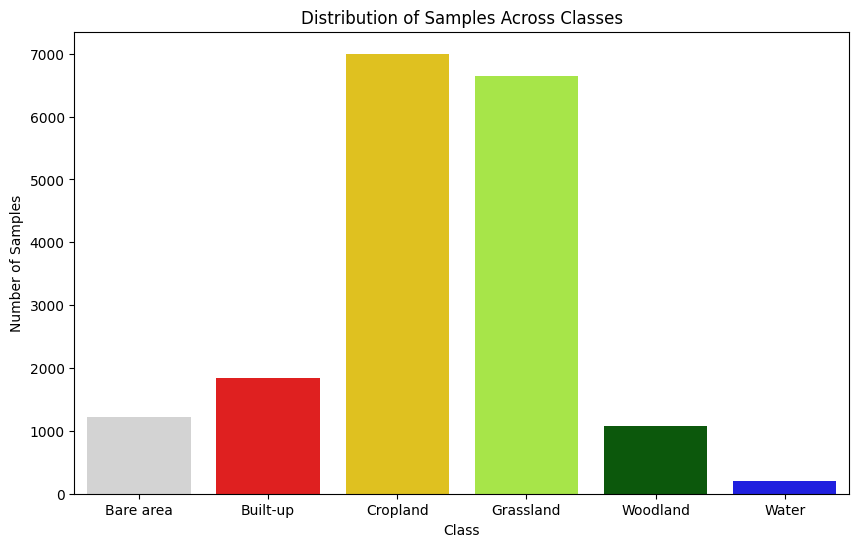

In [ ]:
# Combine X_train with y_train for easy plotting
df_train = X_train.copy()
df_train['class'] = y_train.values

# Set up the figure size
plt.figure(figsize=(10, 6))

# Create a count plot of 'class' to show the distribution of training samples for each class
sns.countplot(
    x='class',        # The column on the x-axis
    data=df_train,    # The DataFrame containing our features and labels
    palette=Palette   # Use the predefined color palette for each class
)

# Add a title to the plot
plt.title('Distribution of Samples Across Classes')

# Label the x-axis
plt.xlabel('Class')

# Label the y-axis
plt.ylabel('Number of Samples')

# Customize the x-ticks to show class names instead of numbers
plt.xticks(
    ticks=[0, 1, 2, 3, 4, 5],                           # Positions for each class
    labels=['Bare area', 'Built-up', 'Cropland',        # Human-readable class names
            'Grassland', 'Woodland', 'Water']
)

# Display the plot
plt.show()

### Scatter plot
Next, create a scatter plot using the seaborn library. By analyzing how predictor variables (e.g., spectral bands) relate to each other and to the land cover classes, we can identify useful features for classification.

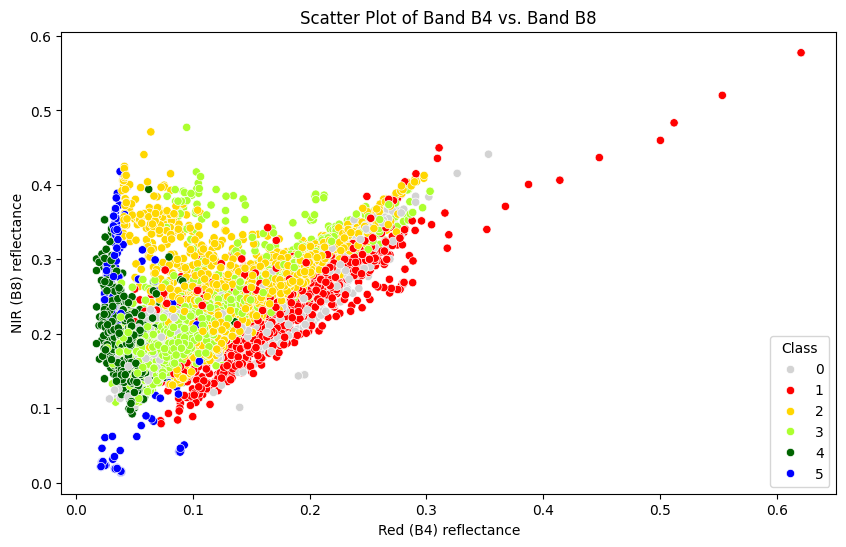

In [ ]:
# Combine X_train with y_train for easy plotting
df_train = X_train.copy()
df_train['class'] = y_train.values

# Scatter plot of B4 vs B8, colored by 'class'
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='B4',
    y='B8',
    hue='class',
    data=df_train,
    palette=Palette
)
plt.title('Scatter Plot of Band B4 vs. Band B8')
plt.xlabel('Red (B4) reflectance')
plt.ylabel('NIR (B8) reflectance')
plt.legend(title='Class')
plt.show()

### Pairwise scatter plots
Next, we create pairwise scatter plots to visualize how each pair of spectral bands (e.g., B2 vs. B3, B2 vs. B4, etc.) relates to one another across the different classes. This helps us spot patterns, cluster tendencies, or any obvious band relationships, and it allows us to see if certain classes are well-separated (or highly overlapping) when viewed in different band combinations. Essentially, it’s a quick way to explore the distribution and separability of classes in a multi-dimensional feature space.

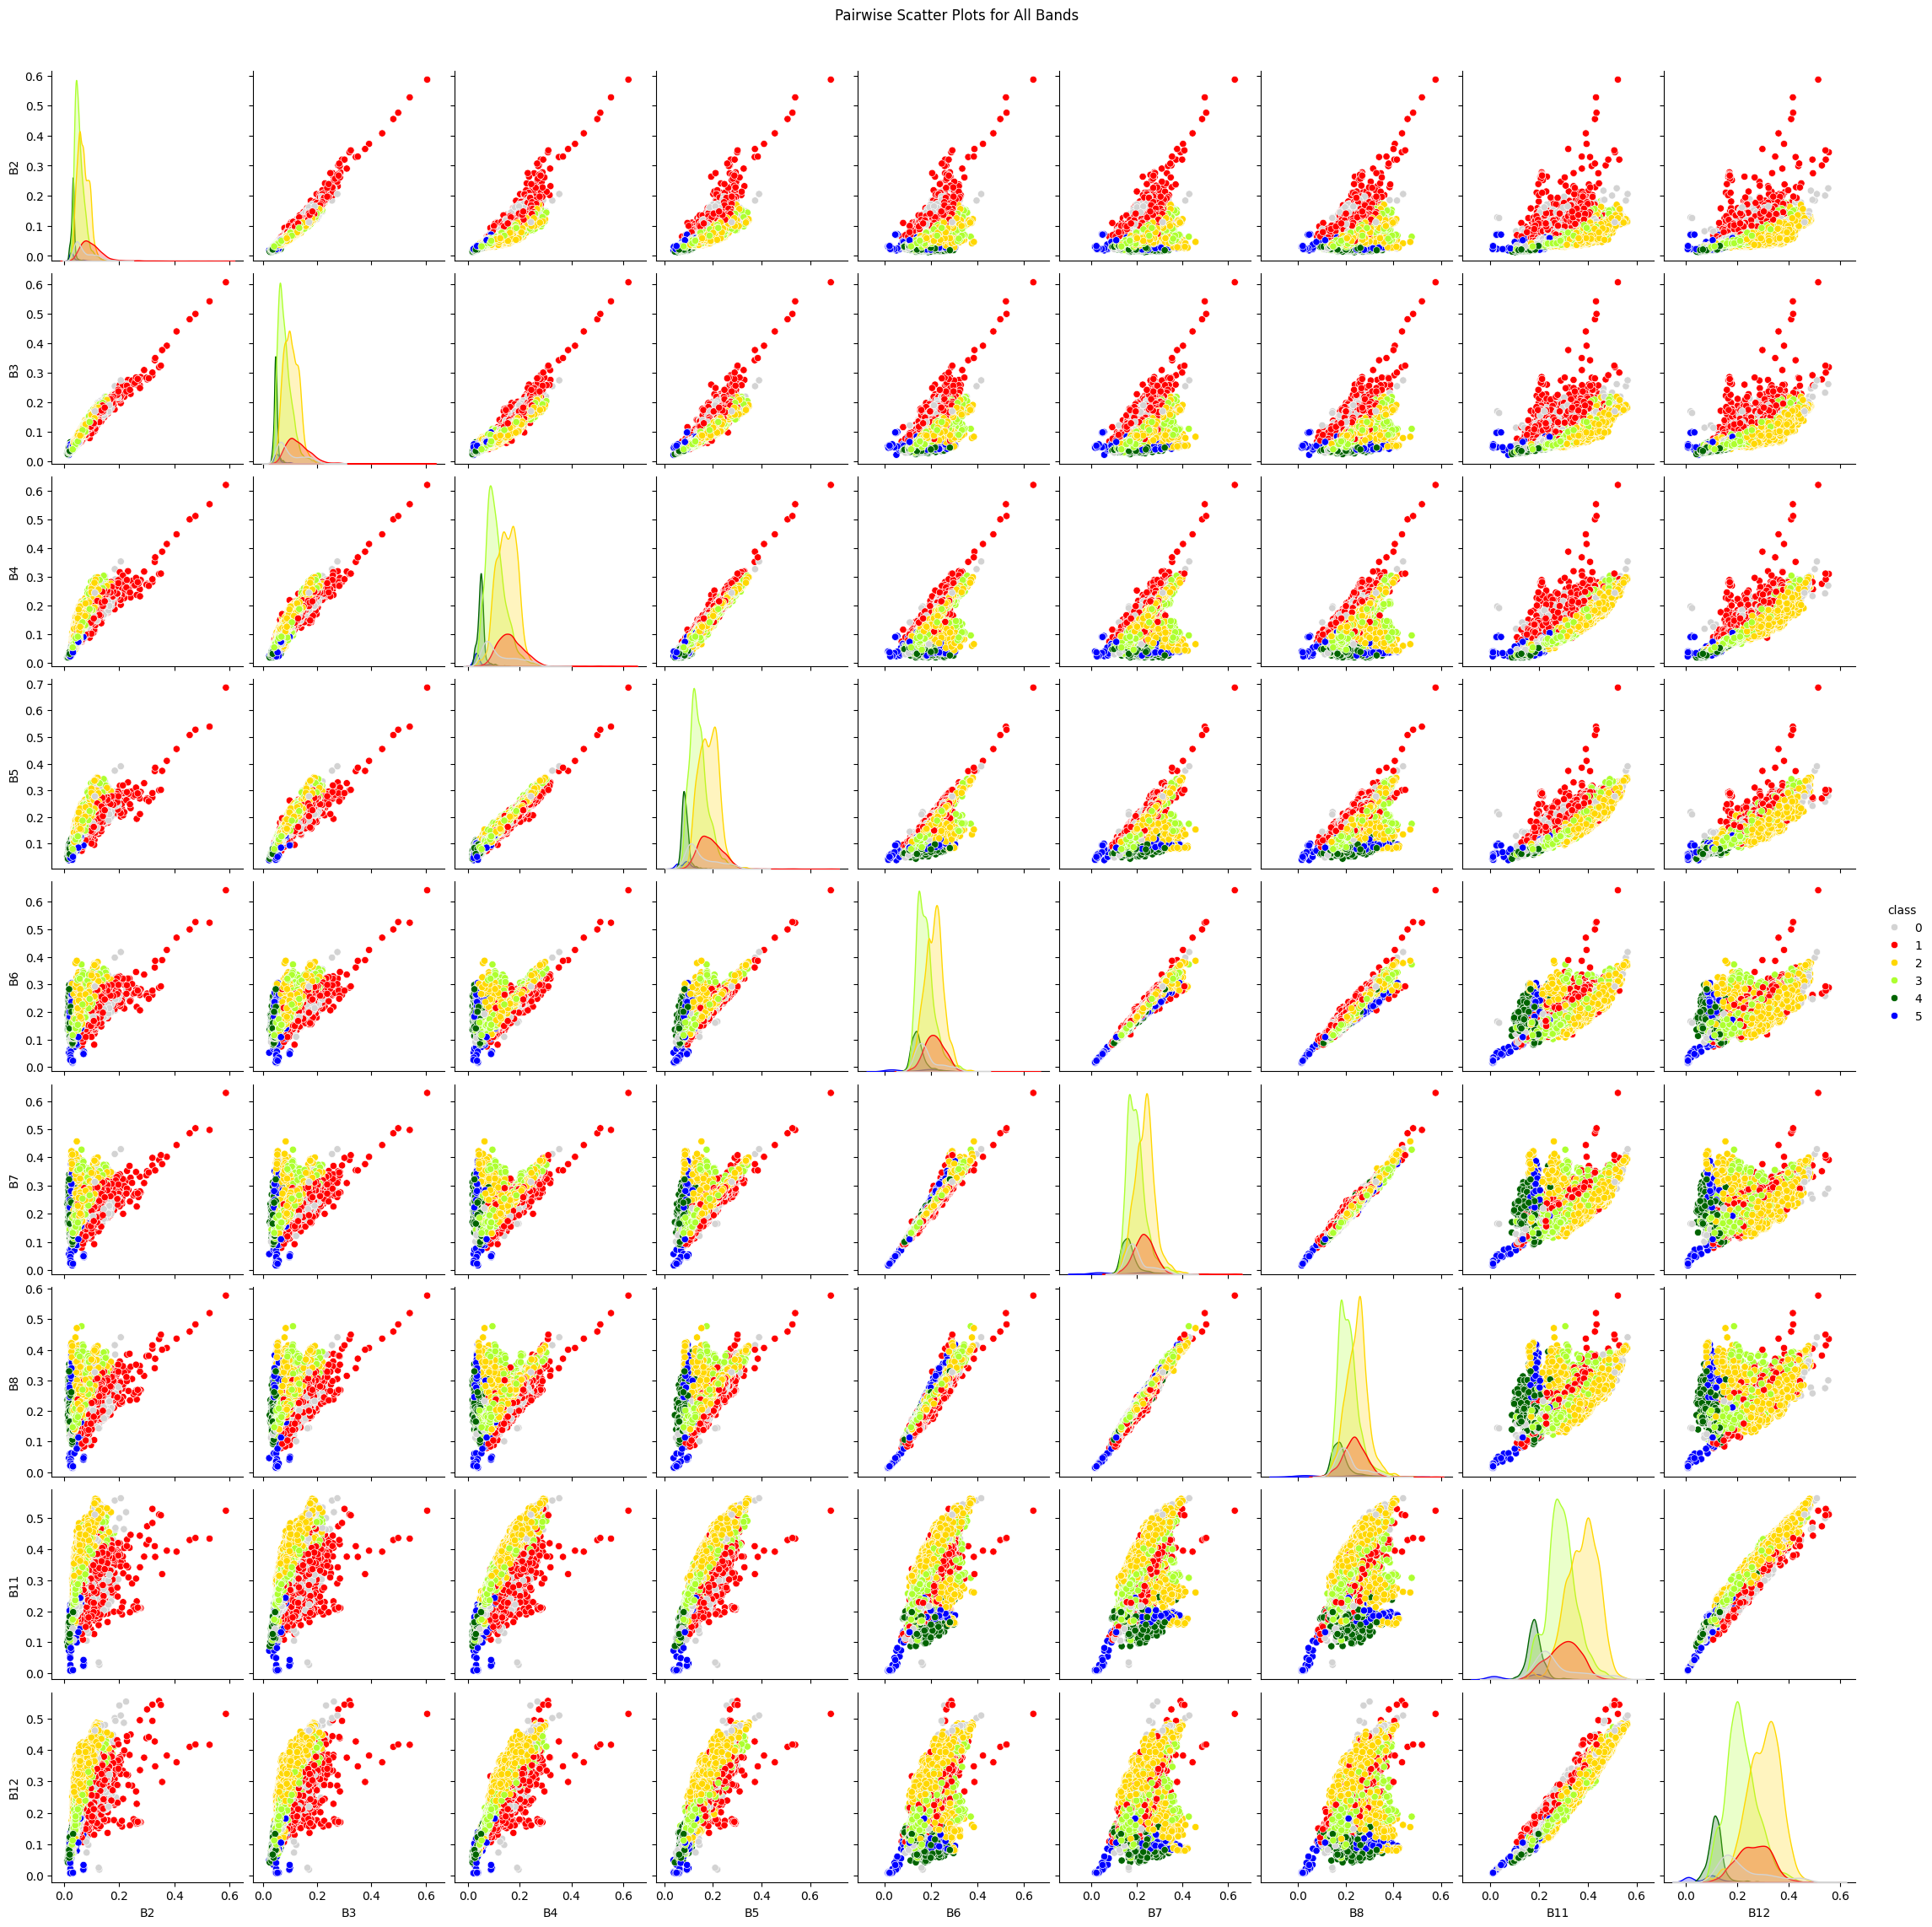

In [ ]:
# Create the pairplot
g = sns.pairplot(df_train, vars=Bands, hue='class', palette=Palette)

# Add a main title (pairplot returns a PairGrid object, so we need g.fig)
g.fig.suptitle('Pairwise Scatter Plots for All Bands', y=1.02)

plt.show()

### 3D scatter plots
Next, let's create a 3D scatter plot for the Sentinel-2 Blue (B2), Red (B4), and Near-Infrared (B8) bands using matplotlib. A 3D plot allows you to visualize the relationships among three different bands (e.g., Blue, Red, and Near Infrared) simultaneously, rather than just two at a time. This can reveal additional patterns or cluster separations in the feature space—for instance, whether certain classes become more distinguishable when you add a third dimension. It’s simply a more in-depth way to explore how your classes are distributed across multiple bands and can help you quickly spot any interesting trends or outliers.

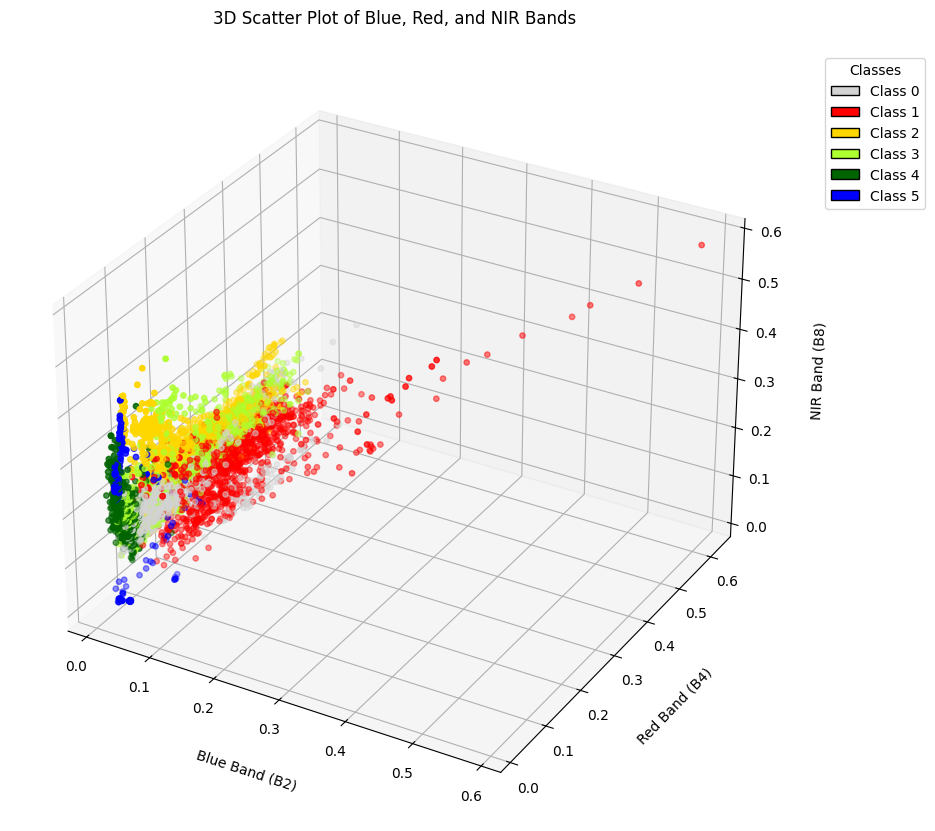

In [ ]:
# Libraries needed
from mpl_toolkits.mplot3d import Axes3D  # needed for 3D projections
from matplotlib.patches import Patch

# Create a color map from class labels to colors in the palette
color_map = {class_label: Palette[i] for i, class_label in enumerate(Classes)}

# Map each sample's class label to its corresponding color
colors = df_train['class'].map(color_map)

# Initialize the figure and 3D axis
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot:
#   x-axis => B2 (Blue)
#   y-axis => B4 (Red)
#   z-axis => B8 (NIR)
scatter = ax.scatter(
    df_train['B2'],
    df_train['B4'],
    df_train['B8'],
    c=colors,
    s=15  # point size (optional)
)

# Label the axes
ax.set_xlabel('Blue Band (B2)', labelpad=15)
ax.set_ylabel('Red Band (B4)', labelpad=15)
ax.set_zlabel('NIR Band (B8)', labelpad=15)

# Adjust distance of the "camera" to the plot (optional)
ax.dist = 11

# (Optional) Adjust the viewing angle for better orientation
# ax.view_init(elev=20, azim=30)  # e.g., 20° above, 30° rotation

# Create a custom legend
legend_elements = [
    Patch(facecolor=Palette[i], edgecolor='k', label=f'Class {Classes[i]}')
    for i in range(len(Classes))
]
ax.legend(
    handles=legend_elements,
    title="Classes",
    loc='upper left',
    bbox_to_anchor=(1.05, 1)  # move legend outside the plot if you want
)

# Add a title
plt.title('3D Scatter Plot of Blue, Red, and NIR Bands', pad=20)

plt.show()

### Create t-distributed Stochastic Neighbor (t-SNE)
We will create a t-SNE plot, a popular technique for dimensionality reduction that is especially useful to visualize high-dimensional data in a lower-dimensional (2D or 3D) space.

To create a t-SNE plot, first import the necessary libraries, including TSNE from sklearn.manifold. Next, prepare your feature matrix (X) and labels (y): X should be a two-dimensional array with shape [n_samples,n_features][n_samples,n_features], and y should contain the corresponding class labels. When initializing t-SNE, specify parameters such as n_components=2 for a 2D projection, adjust perplexity (commonly in the range of 5 to 50) to balance local and global relationships in the data, and set n_iter to control how many iterations are performed during the embedding process. After calling tsne.fit_transform(X), you will get the 2D embedding, which you can plot by assigning each point’s x- and y-coordinates from X_tsne and coloring them according to their label. Finally, customize the plot by adjusting the size of markers, transparency, labels, titles, and legends to suit your visualization preferences.

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


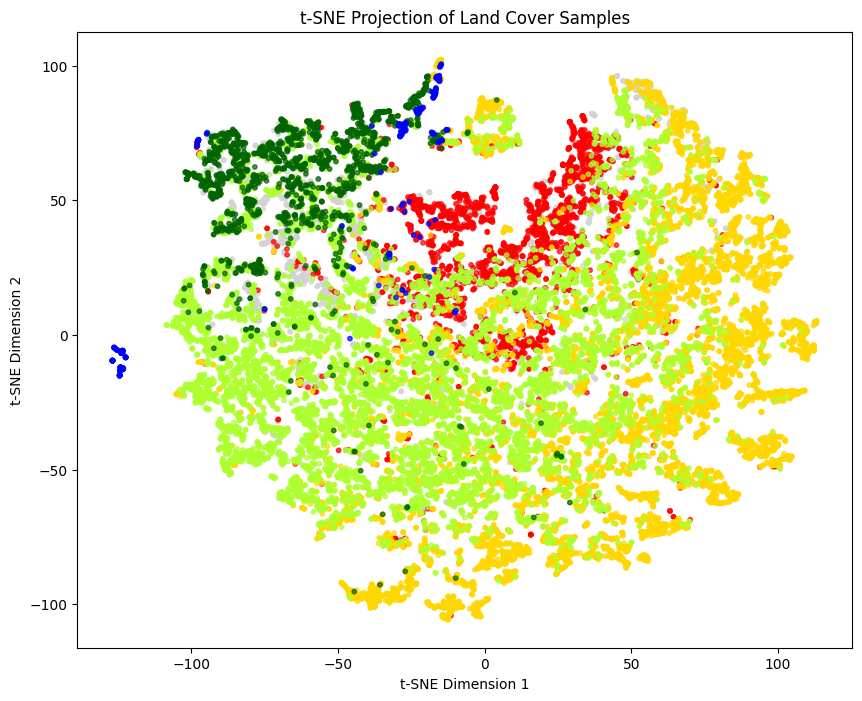

In [ ]:
# Import TSNE
from sklearn.manifold import TSNE

# 1. Initialize the t-SNE model
tsne = TSNE(
    n_components=2,  # Project down to 2D
    perplexity=30,   # Typical range is 5-50; tune as needed
    random_state=42, # For reproducibility
    n_iter=1000      # Number of gradient descent iterations
)

# 2. Fit and transform your feature matrix
X_tsne = tsne.fit_transform(X)

# 3. Plot the results
plt.figure(figsize=(10, 8))

# color_map = {class_label: Palette[i] for i, class_label in enumerate(Classes)}
colors = [color_map[label] for label in y]

plt.scatter(
    X_tsne[:, 0],  # t-SNE x-coordinates
    X_tsne[:, 1],  # t-SNE y-coordinates
    c=colors,
    s=10,          # Marker size
    alpha=0.7      # Transparency
)

plt.title("t-SNE Projection of Land Cover Samples")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# (Optional) Add a legend
# If you have a legend, you can manually create it or use existing patches
# or you can skip the legend if it becomes cluttered in high-dimensional data

plt.show()

### Create box plots
Next, we create box plots for all training data bands, grouped by land cover class.

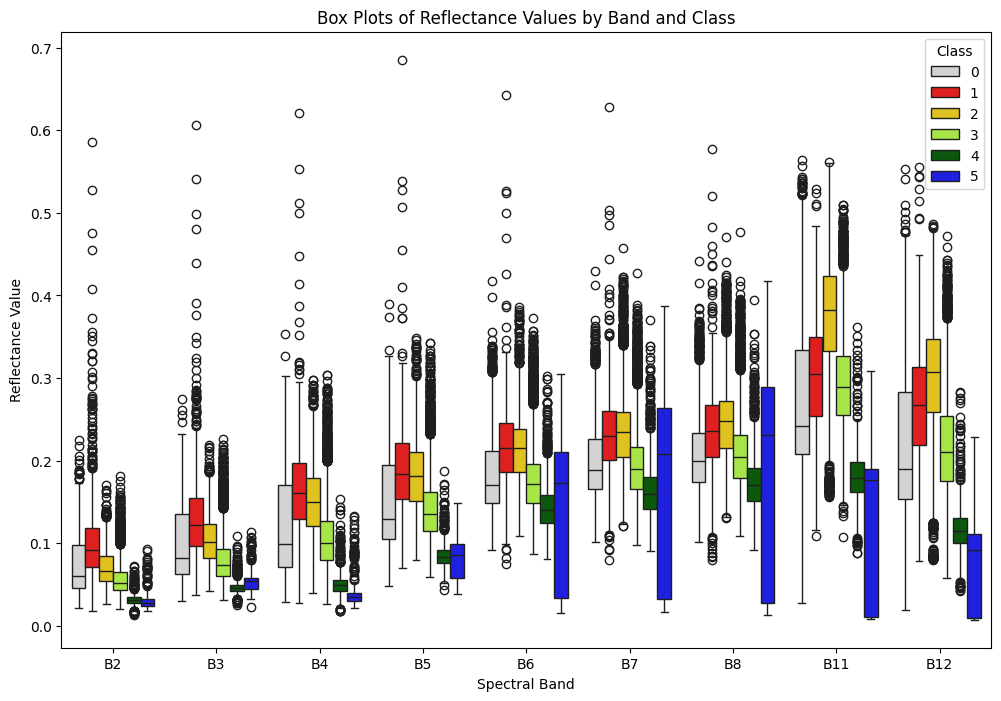

In [ ]:
# 1. Melt the DataFrame into a "long" format for box plotting
df_melt = df_train.melt(
    id_vars='class',               # Keep 'class' as an identifier
    value_vars=Bands,              # The band columns to melt
    var_name='Band',               # Name for the new "band" column
    value_name='Reflectance'       # Name for the new "reflectance" column
)

# 2. Create a box plot
plt.figure(figsize=(12, 8))
sns.boxplot(
    x='Band',
    y='Reflectance',
    hue='class',
    data=df_melt,
    palette=Palette                # (Optional) use the predefined color palette
)

# 3. Customize the plot
plt.title("Box Plots of Reflectance Values by Band and Class")
plt.xlabel("Spectral Band")
plt.ylabel("Reflectance Value")
plt.legend(title="Class", loc="upper right")

# 4. Display the plot
plt.show()

## Train and Evaluate Multiple Classifiers

We will train four classifiers: K-nearest neighbors (KNN), support vector machine (SVM), decision tree, and random forest. Then we will compare their performance using accuracy, confusion matrices, and classification reports.

In [ ]:
# 1) KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_preds = knn.predict(X_test)

# 2) SVM
svm = SVC(kernel='rbf', C=1)
svm.fit(X_train, y_train)
svm_preds = svm.predict(X_test)

# 3) Decision Tree
dt = DecisionTreeClassifier(max_depth=10, random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)

# 4) Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

### Model validation
We will compare their performance using accuracy, confusion matrices, and classification reports.


** KNN **
Accuracy: 0.8128647386849954
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       520
           1       0.83      0.76      0.79       792
           2       0.86      0.87      0.86      3000
           3       0.79      0.82      0.81      2849
           4       0.76      0.69      0.72       464
           5       0.90      0.92      0.91        86

    accuracy                           0.81      7711
   macro avg       0.80      0.78      0.79      7711
weighted avg       0.81      0.81      0.81      7711



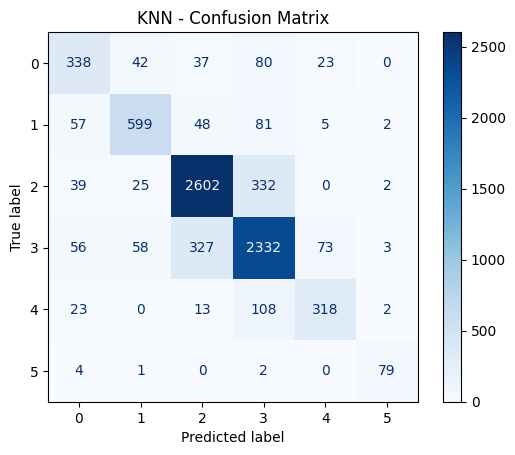


** SVM **
Accuracy: 0.7506160031124368
              precision    recall  f1-score   support

           0       0.72      0.27      0.39       520
           1       0.75      0.83      0.79       792
           2       0.80      0.82      0.81      3000
           3       0.71      0.75      0.73      2849
           4       0.65      0.71      0.68       464
           5       0.94      0.59      0.73        86

    accuracy                           0.75      7711
   macro avg       0.76      0.66      0.69      7711
weighted avg       0.75      0.75      0.74      7711



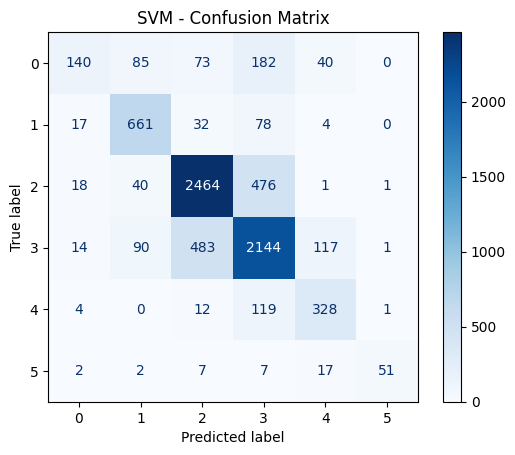


** Decision Tree **
Accuracy: 0.7480223057969135
              precision    recall  f1-score   support

           0       0.60      0.47      0.53       520
           1       0.72      0.69      0.70       792
           2       0.85      0.79      0.82      3000
           3       0.70      0.78      0.74      2849
           4       0.65      0.70      0.67       464
           5       0.90      0.83      0.86        86

    accuracy                           0.75      7711
   macro avg       0.74      0.71      0.72      7711
weighted avg       0.75      0.75      0.75      7711



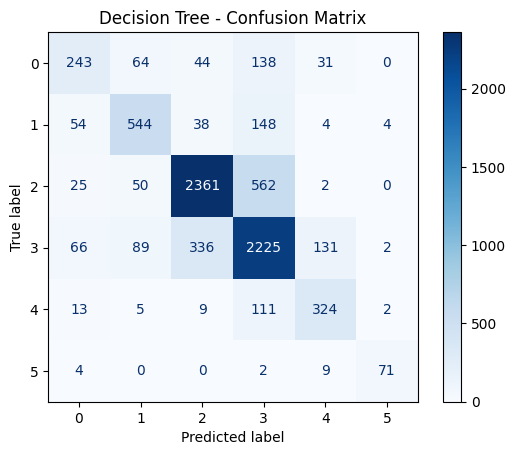


** Random Forest **
Accuracy: 0.8316690442225392
              precision    recall  f1-score   support

           0       0.77      0.60      0.67       520
           1       0.80      0.80      0.80       792
           2       0.88      0.88      0.88      3000
           3       0.81      0.84      0.82      2849
           4       0.78      0.75      0.77       464
           5       0.93      0.91      0.92        86

    accuracy                           0.83      7711
   macro avg       0.83      0.80      0.81      7711
weighted avg       0.83      0.83      0.83      7711



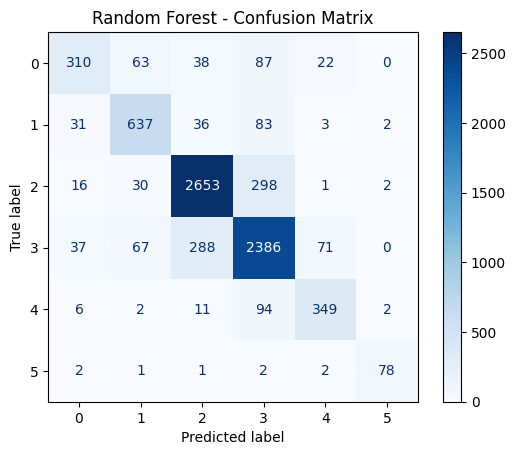

In [ ]:
# Evaluate each model
models = {
    "KNN": knn_preds,
    "SVM": svm_preds,
    "Decision Tree": dt_preds,
    "Random Forest": rf_preds
}

for name, preds in models.items():
    print(f"\n** {name} **")
    print("Accuracy:", (preds == y_test).mean())

    # Classification Report
    print(classification_report(y_test, preds))

    # Confusion Matrix
    cm = confusion_matrix(y_test, preds, labels=Classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=Classes)
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

## Land Cover Classification

Choose one or more of the trained classifiers (e.g., Random Forest for demonstration) to predict class labels for every pixel of the Sentinel-2 image.

### i. Read the full image stack

In [ ]:
# Read all bands as a NumPy array
# shape = (band_count, height, width)
img_array = image.read()

# For example, if the image bands match the ordering of 'Bands' exactly,
# index them accordingly. Make sure the array order aligns with your CSV.
print("Image array shape:", img_array.shape)  # Should be (#bands, height, width)

Image array shape: (9, 4469, 5317)


### ii. Reshape for prediction
Scikit-Learn expects a 2D array for prediction, where each row corresponds to a pixel and each column corresponds to a band. Therefore, we need to reshape from (bands, height, width) to (height*width, bands) for input into Scikit-Learn.

In [ ]:
# Transpose and reshape to [#pixels, #bands]
# If img_array is [bands, rows, cols]:
img_reshaped = img_array.reshape(band_count, -1).T  # shape => (rows*cols, bands)
print("Reshaped array for prediction:", img_reshaped.shape)

Reshaped array for prediction: (23761673, 9)


iii.  Predict and reshape back
Use the random forest for prediction and reshape the presiction back.

In [ ]:
# Use Random Forest as an example
prediction = rf.predict(img_reshaped)

# Change to an appropriate data type
prediction = prediction.astype(np.uint8)

# Reshape the prediction back to [height, width]
prediction_map = prediction.reshape(height, width)
print("Predicted map shape:", prediction_map.shape)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Predicted map shape: (4469, 5317)


### Visualize the land cover map

Next, visualize the resulting map with a color palette corresponding to each class ID.

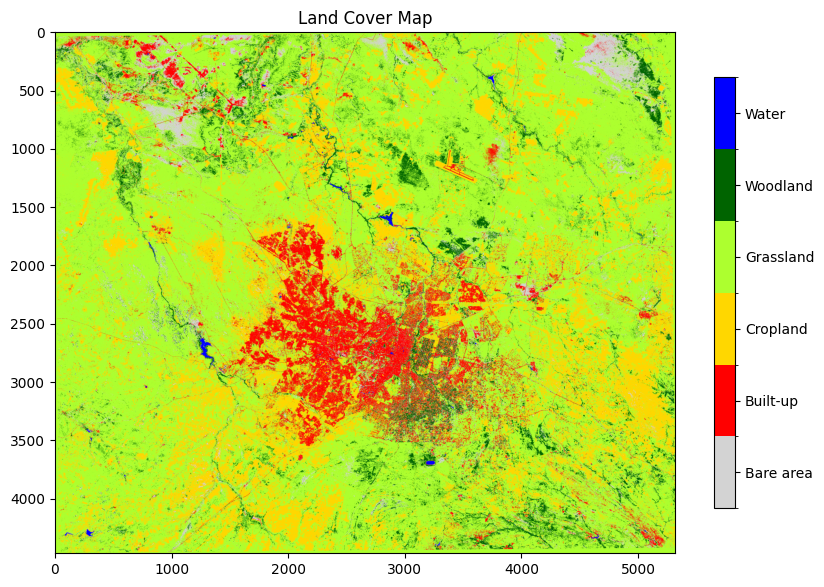

In [ ]:
# Prepare a discrete colormap
# We need one more level than classes for from_levels_and_colors
levels = Classes + [max(Classes) + 1]
cmap, norm = from_levels_and_colors(levels, Palette)

plt.figure(figsize=(10,8))
im = plt.imshow(prediction_map, cmap=cmap, norm=norm)
plt.title("Land Cover Map")

# Create colorbar with a shrink factor (0.7 = 70% of default height)
cbar = plt.colorbar(im, shrink=0.7)

# Center tick labels
tick_positions = [i + 0.5 for i in Classes]
cbar.set_ticks(tick_positions)
cbar.set_ticklabels(Names)

plt.show()

## Export the Land Cover Map
We can save the land cover map to a new GeoTIFF using rasterio.

In [ ]:
# Save the land cover map
output_path = '/content/drive/MyDrive/Bulawayo_Dataset_2024/Bul_RF_LC_2024.tif'
with rasterio.open(
    output_path,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,              # single band
    dtype=prediction_map.dtype,
    crs=crs,
    transform=transform
) as dst:
    dst.write(prediction_map, 1)

print("Classification result exported to:", output_path)

Classification result exported to: /content/drive/MyDrive/Bulawayo_Dataset_2024/Bul_RF_LC_2024.tif
